# DCT and JPEG Compression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Helper Functions

In [2]:
def EvenExtension(f):
    '''
     fe = EvenExtension(f)
     
     Performs an even extension on the array f.
    
     Input:
       f is a 2D array
    
     Output:
       fe is the even extension of f
    
     If f has dimensions NxM, then fe has dimensions
        (2*N-2)x(2*M-2)
     and fe[n,j]=fe[-n,j] for n=0,...,N-1
     and fe[n,j]=fe[n,-j] for j=0,...,M-1
    
     For example, if f is 5x4, then fe has dimensions 8x6.
    
     IEvenExtension is the inverse of EvenExtension, so that
        IEvenExtension(EvenExtension(f)) == f
     for any matrix f.
    
    '''
    fe = np.concatenate((f, np.fliplr(f[:,1:-1])), axis=1)
    fe = np.concatenate((fe, np.flipud(fe[1:-1,:])), axis=0)
    return fe

def IEvenExtension(fe):
    '''
     f = IEvenExtension(fe)
    
     Reverses the action of an even extension.
    
     Input:
       fe is a 2D array, assumed to contain an even extension
    
     Output:
       f is the sub-array that was used to generate the extension
    
     If fe has dimensions KxL, then f has dimensions
        ceil((K+1)/2) x ceil((L+1)/2)
     For example, if fe is 8x6, then f is 5x4.
    
     IEvenExtension is the inverse of EvenExtension, so that
        IEvenExtension(EvenExtension(f)) == f
     for any matrix f.
    
    '''
    e_dims = np.array(np.shape(fe))
    dims = np.ceil((e_dims + 1.) / 2)
    dims = np.array(dims, dtype=int)
    f = fe[:dims[0], :dims[1]]
    return f

def NumPixels(f):
    '''
     n = NumPixels(f) returns the total number of elements in the array f.
     
     For example,
       NumPixels( np.ones((5,4)) )
     returns the value 20.
    '''
    return np.prod(np.shape(f))

def Show(g, title=''):
    '''
     Show(g, title='')
     
     Displays the image g as a graylevel image with intensities
     clipped to the range [0,255].
    '''
    plt.imshow(np.clip(g, a_min=0, a_max=255), cmap='gray');
    plt.axis('off');
    plt.title(title);

In [3]:
# Define a simple 2-D array for demo
f = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]], dtype=float)
print(f)

[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]]


In [4]:
# Even extension
fe = EvenExtension(f)
print(fe)

[[ 1.  2.  3.  4.  3.  2.]
 [ 5.  6.  7.  8.  7.  6.]
 [ 9. 10. 11. 12. 11. 10.]
 [ 5.  6.  7.  8.  7.  6.]]


In [5]:
# Inverse even extension
g = IEvenExtension(fe)
print(g)

[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]]


## Discrete Cosine Transform

In [6]:
def dct(f):
    '''
     Fdct = dct(f)
    
     Computes the 2-D Discrete Cosine Transform of input image f.
     It uses an even extension of f, along with the 2D-DFT.
     This function is the inverse of idct.
    
     Input:
      f is a 2-D array of real values
    
     Output:
      Fdct is a real-valued array the same size as f
    '''
    # Even extension
    g = EvenExtension(f)
    
    # Compute fft2
    g = np.fft.fft2(g)
    
    # Extract coefficients
    g = g[:f.shape[0], :f.shape[1]]
    
    # Ensure the result is real
    return g.real

## Inverse Discrete Cosine Transform

In [7]:
def idct(Fdct):
    '''
     f = idct(Fdct)
    
     Computes the 2-D Inverse Discrete Cosine Transform (IDCT) of input
     array Fdct. It uses an even extension of Fdct, along with the 2D-IDFT.
     This function is the inverse of dct.
    
     Input:
      Fdct is a 2-D array of real values
    
     Output:
      f is a real-valued array the same size as Fdct
    '''
    # Even extension on Fdct
    g = EvenExtension(Fdct)
    
    # Compute ifft2
    g = np.fft.ifft2(g)
    
    # Perform inverse even extension
    g = IEvenExtension(g)
    
    # Ensure the result is real
    return g.real

## JPEG Compress

In [8]:
def compress(f, T, D):
    '''
     G = compress(f, T, D)
    
     Input
        f is the input image, a 2D array of real numbers
        T is the tile size to break the input image into
        D is the size of the block of Fourier coefficients to keep
          (Bigger values of D result in less loss, but less compression)
    
     Output
        G is the compressed encoding of the image
    
     Example: If f is 120x120, then
    
        G = compress(f, 10, 4)
    
     would return an array (G) of size 48x48.
    '''
    # Compute the result dimension of output array G
    dim = np.floor(np.array(f.shape) / T) * D
    
    # Initialize output array with 0s
    G = np.zeros(dim.astype(int))
    
    # Iterate through each of the T x T tiles
    for i in range(f.shape[0] // T):
        for j in range(f.shape[1] // T):
            # Extract current T x T tile from f
            tile = f[i * T:(i + 1) * T, j * T:(j + 1) * T]
      
            # Compute DCT on the tile
            tile = dct(tile)
            
            # Extract a D x D subarray of low frequencies
            subarray = tile[:D, :D]
            
            # Put subarray into G at correct position
            G[i * D:(i + 1) * D, j * D:(j + 1) * D] = subarray
            
    # Return result
    return G

## JPEG Decompress

In [9]:
def decompress(G, T, D):
    '''
     f = decompress(G, T, D)
    
     Input
        G is the compressed encoding, a 2D array of real numbers
        T is the tile size for reassembling the decompressed image
        D is the size of the blocks of Fourier coefficients that were
          kept when the image was compressed
          (Bigger values of D result in less loss, but less compression)
    
     Output
        f is the decompressed, reconstructed image
    
     Example: If G is 48x48, then
    
        f = decompress(G, 10, 4);
    
     would return an array (f) of size 120x120.
    '''
    # Compute result dimension of f
    dim = np.array(G.shape) / D * T
    
    # Initialize array f with 0s
    f = np.zeros(dim.astype(int))
    
    # Iterate through each D x D block
    for i in range(G.shape[0] // D):
        for j in range(G.shape[1] // D):
            # Initialize a T x T tile of zeros
            tile = np.zeros((T, T))
            
            # Extract current D x D block in G
            block = G[i * D:(i + 1) * D, j * D:(j + 1) * D]
            
            # Put block into tile
            tile[:D, :D] = block
            
            # Call IDCT on tile
            tile = idct(tile)
            
            # Put tile into f at correct position
            f[i * T:(i + 1) * T, j * T:(j + 1) * T] = tile
    
    # Return result
    return f

## Compression Demo

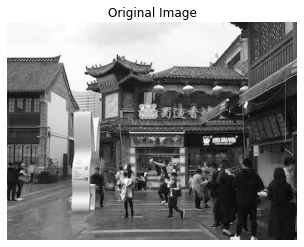

In [10]:
f = plt.imread('Jinan.jpg')[:,:,0]
Show(f, 'Original Image')

Compression Ratio: 4.0


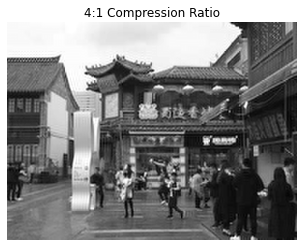

In [11]:
c1 = compress(f, 20, 10)
Show(decompress(c1, 20, 10), '4:1 Compression Ratio')

# Check to make sure the ratio is 4:1
print('Compression Ratio: ' + str(NumPixels(f) / NumPixels(c1)))

Compression Ratio: 16.0


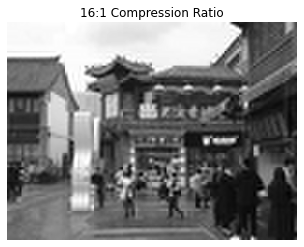

In [12]:
c2 = compress(f, 20, 5)
Show(decompress(c2, 20, 5), '16:1 Compression Ratio')

# Check to make sure the ratio is 16:1
print('Compression Ratio: ' + str(NumPixels(f) / NumPixels(c2)))

Compression Ratio: 25.0


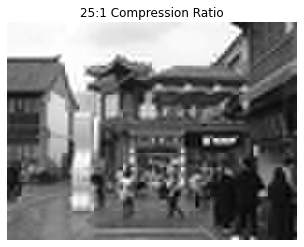

In [13]:
c3 = compress(f, 20, 4)
Show(decompress(c3, 20, 4), '25:1 Compression Ratio')

# Check to make sure the ratio is 25:1
print('Compression Ratio: ' + str(NumPixels(f) / NumPixels(c3)))